# 1. Clustering (군집분석)

- Unsupervised Learning: Y label이 없는 데이터에서 패턴을 찾는 방법
- Clustering: 거리가 가까운 관측치들 간 유사한 특징이 있을 것이라는 가정을 기반으로 변수들을 군집화
  - 정답이 없으므로 탐색 인사이트 용도로 사용
  - 대부분 optimization 문제를 푸는 경우가 많음
  - 1) 계층적 클러스터링 (hierarchical clustering)과 2) 비계층적 클러스터링(K-means clustering)으로 구분됨
    - 1) 거리행렬을 기반으로 가까운 대상끼리 순차적으로 그룹을 할당
    - 2) 랜덤한 시작점에서 해당 점과 가까운 대상 간 그룹 할당

- 이상치가 존재할 경우 클러스터링 진행 시 영향을 많이 받을 수 있으므로 사전에 제거 과정이 필요

In [ ]:
import warnings
warnings.filterwarnings(action='ignore')

In [ ]:
import pandas as pd
data = pd.read_csv('https://raw.githubusercontent.com/jej0312/DM_TA/main/data/fa_data_bfi.csv')

In [ ]:
from IPython.display import display
display(data.head())
print('\n', data.shape)

Neuroticism  Extraversion  Conscientiousness  Agreeableness   Openess
0    -0.439830      0.103897          -1.216713      -0.696215 -1.519449
1     0.084369      0.559311          -0.601521      -0.189341 -0.248384
2     0.520534      0.318235           0.025646      -0.751136  0.204503
3    -0.197064      0.057696          -1.019263       0.064286 -1.029492
4    -0.329835      0.408754          -0.058843      -0.820454 -0.691042


 (2436, 5)


In [ ]:
# 이상치 제거 함수 (1Q - 1.5*IQR, 3Q + 1.5*IQR 을 넘어가는 값을 가진 행을 제거)
import numpy as np

def get_outlier(df=None, column=None, weight=1.5):
  quantile_25 = np.percentile(df[column].values, 25)
  quantile_75 = np.percentile(df[column].values, 75)

  IQR = quantile_75 - quantile_25
  IQR_weight = IQR*weight

  lowest = quantile_25 - IQR_weight
  highest = quantile_75 + IQR_weight

  outlier_idx = df[column][ (df[column] < lowest) | (df[column] > highest) ].index
  return outlier_idx

In [ ]:
for col in data.columns:
    outlier_idx = get_outlier(df=data, column=col, weight=1.5)
    data.drop(outlier_idx, axis=0, inplace=True)

In [ ]:
display(data.head())
print('\n', data.shape)

Neuroticism  Extraversion  Conscientiousness  Agreeableness   Openess
0    -0.439830      0.103897          -1.216713      -0.696215 -1.519449
1     0.084369      0.559311          -0.601521      -0.189341 -0.248384
2     0.520534      0.318235           0.025646      -0.751136  0.204503
3    -0.197064      0.057696          -1.019263       0.064286 -1.029492
4    -0.329835      0.408754          -0.058843      -0.820454 -0.691042


 (2335, 5)


- large scale 데이터를 사용할 경우 계산량이 많아지며, 클러스터링 시 값의 range의 영향을 받기 때문에 표준화/scaling이 필요

In [ ]:
data.describe() # 기초통계량

Neuroticism  Extraversion  Conscientiousness  Agreeableness  \
count  2335.000000   2335.000000        2335.000000    2335.000000   
mean      0.003113      0.030340           0.025799       0.054182   
std       0.913940      0.836298           0.821891       0.764686   
min      -2.011680     -2.287489          -2.320576      -2.107187   
25%      -0.718653     -0.498024          -0.526410      -0.439648   
50%      -0.056327      0.097684           0.088043       0.142092   
75%       0.650523      0.655036           0.634843       0.614244   
max       2.551124      2.336969           1.893386       2.179653   

           Openess  
count  2335.000000  
mean      0.003259  
std       0.808914  
min      -2.294768  
25%      -0.570231  
50%       0.025512  
75%       0.609261  
max       2.011314

In [ ]:
from sklearn.preprocessing import StandardScaler
scaled = StandardScaler().fit_transform(data)

In [ ]:
scaled = pd.DataFrame(scaled, columns = data.columns)
scaled.describe() # 기초통계량

Neuroticism  Extraversion  Conscientiousness  Agreeableness  \
count  2.335000e+03  2.335000e+03       2.335000e+03   2.335000e+03   
mean  -1.435920e-17 -1.359845e-17       4.052195e-17   1.141129e-18   
std    1.000214e+00  1.000214e+00       1.000214e+00   1.000214e+00   
min   -2.204987e+00 -2.772128e+00      -2.855461e+00  -2.827083e+00   
25%   -7.899000e-01 -6.319241e-01      -6.720208e-01  -6.459321e-01   
50%   -6.505121e-02  8.054349e-02       7.574925e-02   1.149865e-01   
75%    7.085238e-01  7.471380e-01       7.411858e-01   7.325648e-01   
max    2.788539e+00  2.758732e+00       2.272792e+00   2.780129e+00   

            Openess  
count  2.335000e+03  
mean   5.230173e-17  
std    1.000214e+00  
min   -2.841488e+00  
25%   -7.091154e-01  
50%    2.751602e-02  
75%    7.493164e-01  
max    2.482941e+00

# 계층적 클러스터링 (Hierarchical Clustering)
- 거리 행렬을 기반으로 유사한 관측치끼리 묶음
  - 모든 관측치들 간 거리를 계산함
- 거리를 어떻게 계산할지에 따라 linkage method 구분  
  1) 최단연결법 (single): 생성된 군집에서 중심과 거리가 **가까운** 관측치끼리 군집화  
  2) 최장연결법 (complete): 생성된 군집에서 중심과 거리가 **먼** 관측치끼리 군집화  
  3) 평균연결법 (average): 군집 내 모든 데이터와 다른 군집 내 모든 데이터 간의 거리 **평균**을 계산하여 군집화  
  4) 중앙연결법 (centroid): 군집 내 **centroid**과 다른 군집 내 median까지의 거리를 계산하여 가까운 것끼리 군집화  
  5) 와드연결법 (ward): 거리가 아닌, 군집 내 오차 제곱합(within group sum of squares)이 최소가 되도록 최소가 되도록 군집화

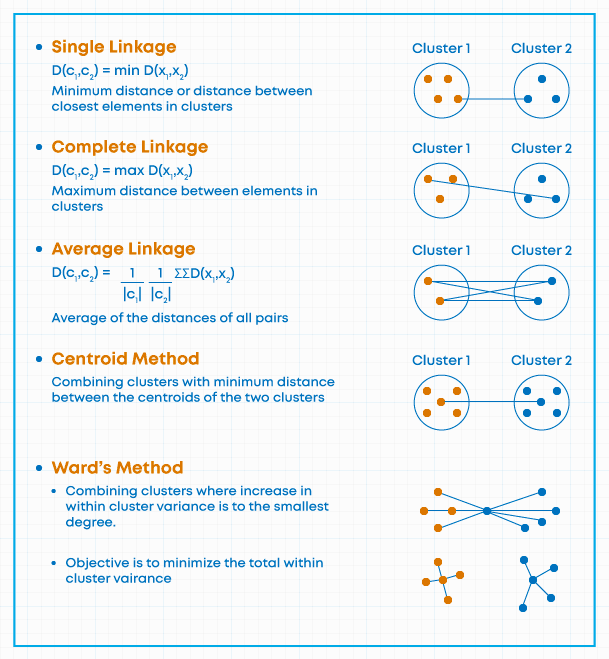

- 장점
    - 클러스터 생성 과정에 대해 이해할 수 있음
    - 사전에 클러스터의 수를 지정하지 않아도 됨
    - 덴드로그램을 통해 클러스터의 수를 결정하는 과정이 쉬움
- 한계
    - 방대한 양의 데이터에서 제대로 작동하지 않을 수 있음
    - 두 클러스터를 결합한 이후에는 그 전으로 돌아갈 수 없음
    - 노이즈 및 이상값에 대해 민감
    - 데이터의 순서가 최종 결과에 영향을 줄 수 있음

## Step 1. 거리 계산에 따른 클러스터링
- `scipy.cluster.hierarchy`의 `linkage` 사용
- [제공하는 linkage 방식](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html#scipy.cluster.hierarchy.linkage)
  -  single, complete, average, centroid, median, ward, weighted
- [제공하는 거리 계산 방식](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.pdist.html#scipy.spatial.distance.pdist)
  - euclidean distance: real-valued 차원에서 각 관측치들의 location을 기반으로 측정 (Euclidean, manhattan, ...)
    - centroid, median, ward linkage method를 사용할 경우 Euclidean pairwise metric만 활용 가능
  - non-euclidean distance: 각 관측치의 거리가 아닌, properties에 의해 측정 (e.g. cosine, jaccard, ...)
    - 이 외에 clustroid 등의 method를 사용할 때 사용 가능

In [ ]:
data_prime = scaled.copy()

In [ ]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
clusters = linkage(y=data_prime, method='complete', metric='euclidean')

## Step 2. 군집 수 결정
- 덴드로그램 (dendrogram): 각 단계에서 군집이 어떻게 형성되는지 확인하고 형성된 군집의 유사성(또는 거리) 수준을 평가  
  - 덴드로그램을 더 높게 커팅할수록 최종 군집 수는 더 작지만 유사성 수준은 더 낮아짐
  - 덴드로그램을 더 낮게 커팅할수록 유사성 수준은 더 높지만 최종 군집 수는 더 많아짐
  - 일부 데이터 집합의 경우 평균, 중심, 중위수 및 Ward의 연결 방법으로 계층적 덴드로그램이 생성되지 않음. (결합 거리가 각 단계에서 항상 증가하지 않을 수 있음)

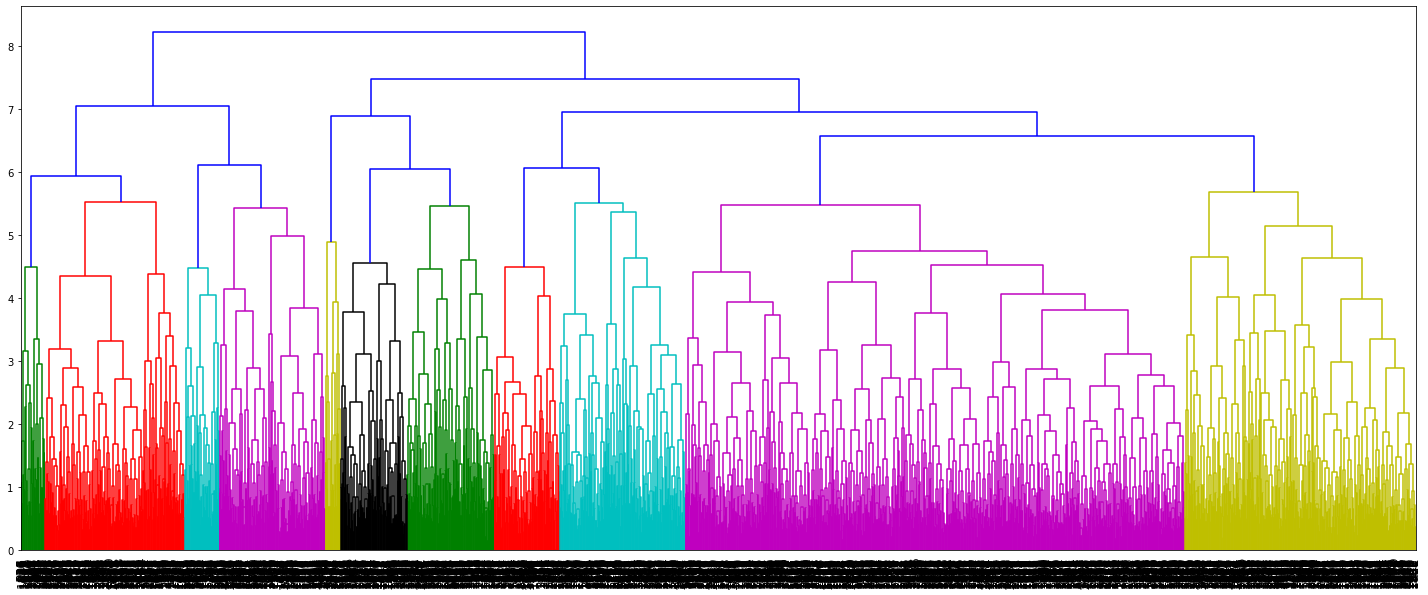

In [ ]:
import matplotlib.pyplot as plt
plt.figure( figsize = (25, 10) )
dendrogram(clusters, leaf_rotation=90, leaf_font_size=12,)
plt.show()

- [`fcluster`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.fcluster.html)을 사용하여 덴드로그램 결과에 기반한 clustering을 진행
- 일반적으로는 (cophenetic)`'distance'` threshold(t)를 기준으로 구분
  - 이 외에도 inconsistent, maxclust, ... 등의 방식이 있음

In [ ]:
cut_tree = fcluster(clusters, t=7, criterion='distance')
cut_tree

array([1, 4, 3, ..., 3, 3, 3], dtype=int32)

In [ ]:
pd.Series(cut_tree).value_counts()

4    1542
3     283
1     275
2     235
dtype: int64

## Step 3. Evaluation
- 군집 내 비유사성 (within dissimilarities)는 작고 군집 간 비유사성 (between dissimilarities)는 크도록 생성
- 이 때, Silhouette coefficient (실루엣 계수)는 각 관측치와 주위 관측치과의 거리 계산을 통해 군집 내 비유사성과 군집 간 비유사성의 정도를 평가
  - 데이터 양이 많아질수록 time complexity가 높음

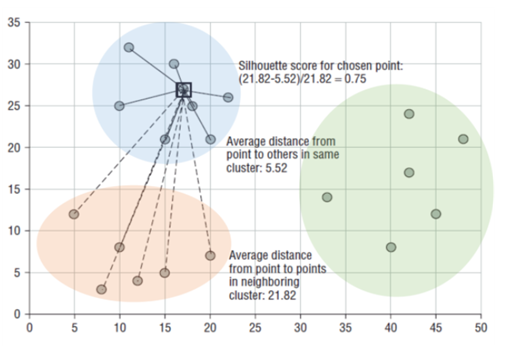

- `silhouette_samples`를 통해 coefficient를 계산, `silhouette_score`를 통해 모든 coefficient의 평균을 계산

In [ ]:
from sklearn.metrics import silhouette_samples, silhouette_score
score_samples = silhouette_samples(data_prime, cut_tree)
print('Silhouette Score:', score_samples[:5], '\nSilhouette Score shape:', score_samples.shape, '\n')

average_score = silhouette_score(data_prime, cut_tree)
# np.mean(score_samples) == average_score: True
print('Silhouette Average Score:{0:.3f}'.format(average_score))

Silhouette Score: [0.26399624 0.04965367 0.02685061 0.23496799 0.11082033] 
Silhouette Score shape: (2335,) 

Silhouette Average Score:0.059


1. 전체 실루엣 계수(0~1)의 평균값이 1에 가까울수록 클러스터링이 잘 진행된 것  
1. 개별 클러스터의 실루엣 계수 평균값의 편차가 작아야 함
  - 클러스터 내 실루엣 계수 평균값을 확인하여, 1에 가까운 클러스터를 'clear-cut cluster', 0에 가까운 클러스터를 'weak cluster'로 표현

In [ ]:
data_prime['hc_cluster'] = cut_tree
data_prime['silhouette_coeff'] = score_samples
data_prime

Neuroticism  Extraversion  Conscientiousness  Agreeableness   Openess  \
0       -0.484757      0.087974          -1.512096      -0.981524 -1.882814   
1        0.088926      0.632650          -0.763428      -0.318530 -0.311154   
2        0.566265      0.344323          -0.000187      -1.053360  0.248836   
3       -0.219074      0.032717          -1.271806       0.013216 -1.276987   
4       -0.364378      0.452584          -0.103007      -1.144029 -0.858497   
...           ...           ...                ...            ...       ...   
2330     1.192595      1.276914          -0.168496      -0.098960 -1.108426   
2331     1.428117     -1.414563          -0.158201      -1.570383  0.505457   
2332     0.798209      0.265352          -0.746378      -0.486530  1.264070   
2333    -0.247750      0.826233           0.926490      -1.455368  1.139852   
2334    -1.852922     -1.653763          -0.130499      -2.497076 -0.206666   

      hc_cluster  silhouette_coeff  
0              1          0.263996  
1              4          0.049654  
2              3          0.026851  
3              1          0.234968  
4              1          0.110820  
...          ...               ...  
2330           4          0.041472  
2331           3          0.027685  
2332           3         -0.045137  
2333           3          0.096256  
2334           3          0.168206  

[2335 rows x 7 columns]

In [ ]:
# 군집별 평균 silhouette_score 값
print(data_prime.groupby('hc_cluster')['silhouette_coeff'].mean())
print('표준편차:', data_prime.groupby('hc_cluster')['silhouette_coeff'].mean().std())

hc_cluster
1    0.155768
2    0.082219
3    0.057706
4    0.038121
Name: silhouette_coeff, dtype: float64
표준편차: 0.05147475615133177


## Step 4. EDA

In [ ]:
# 군집별 통계(평균)
cluster_g = data_prime.groupby('hc_cluster')
cluster_g.mean()

Neuroticism  Extraversion  Conscientiousness  Agreeableness  \
hc_cluster                                                                
1             -0.202224     -0.476430          -0.354750       0.008229   
2              0.641531     -0.987144           0.818133       0.047872   
3             -0.202057     -0.504072          -0.200515      -1.428871   
4             -0.024621      0.327918          -0.024617       0.253474   

             Openess  silhouette_coeff  
hc_cluster                              
1          -1.193593          0.155768  
2           0.429910          0.082219  
3           0.369076          0.057706  
4           0.079611          0.038121

In [ ]:
# 군집별 통계(표준편차)
cluster_g.std()

Neuroticism  Extraversion  Conscientiousness  Agreeableness  \
hc_cluster                                                                
1              0.961289      0.731722           1.000291       0.855926   
2              0.898211      0.795442           0.797586       0.970096   
3              0.873832      1.061641           1.110190       0.690878   
4              1.005253      0.879968           0.939506       0.845658   

             Openess  silhouette_coeff  
hc_cluster                              
1           0.599619          0.090031  
2           1.129314          0.121418  
3           1.062821          0.136505  
4           0.858583          0.126445

- Cluster1: 개방적이지 않은(-O) 사람
- Cluster2: 신경질적(N)인데 외향적이지 않으며(-E) 성실한(C) 사람
- Cluster3: 외향적이지 않고(-E) 쾌활하지 않은(-A) 사람
- Cluster4: 큰 특징이 존재하지 않는 사람

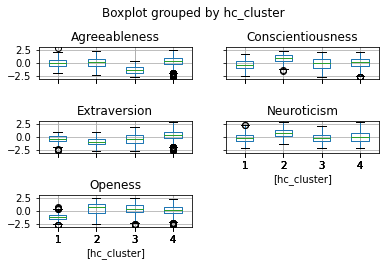

In [ ]:
# 시각화
import matplotlib.pyplot as plt
data_prime.drop('silhouette_coeff', axis=1).boxplot(by='hc_cluster')
plt.tight_layout(pad=3, h_pad=1)
plt.show()

# k-평균 클러스터링 (K-means Clustering)
- Euclidean space를 가정
- [과정](https://eunsukimme.github.io/ml/2019/12/16/K-Means/)  
  1) 클러스터의 개수 k를 선정  
  2) 데이터셋에서 k개의 centroids를 임의로 지정  
  3) 각 데이터들을 가장 가까운 centroids가 속한 그룹에 할당  
  4) 각 클러스터의 centroids 다시 계산 (일반적으로 유클리드 거리 사용)  
  5) 3, 4번 과정을 centroids가 더 이상 변하지 않을 때까지/지정된 횟수까지 반복  

- [한계](https://medium.com/h-document/%ED%81%B4%EB%9F%AC%EC%8A%A4%ED%84%B0%EB%A7%81-%EA%B5%B0%EC%A7%91-%EB%B6%84%EC%84%9D-%EB%B9%84-%EA%B3%84%EC%B8%B5%EC%A0%81-%EA%B5%B0%EC%A7%91-%EB%B6%84%EC%84%9D-ef1a96948d7d)
  - K 결정이 주관적
  - 여러 초기값이 동일 군집에 존재할 경우 최종 결과가 이상해질 수 있음
  - 크기가 작은 그룹에서는 제대로 작동하지 않을 수 있음
  - 반복 특성과 centroid를 random하게 초기화하기 때문에 local optimum에 고착, global optimum에 수렴되지 않을 수 있음

- Extensions
    - k-means에서 initial points로 비슷한 점들이 여러 개 선택되는 경우 불안정한 군집을 학습하게 됨 ([자세한 과정](https://lovit.github.io/nlp/machine%20learning/2018/03/19/kmeans_initializer/))
    - `k-means++`: 1) 첫 initial point를 임의로 선택, 2) 이후의 initial points는 과거 initial points와 멀리 떨어지도록 분포를 조절하여 진행
        - 문서의 bag of words와 같이, 고차원의 sparse 데이터를 군집화하는 과정에서, 대부분의 데이터 간 거리가 유사할 경우 k-means++를 적용하는 것은 expensive한 버전의 random sampling을 수행하는 것과 같음
    - `SphericalKMeans`: k-means++가 가지는 한계를 완화하기 위해 등장. 2)에서 다음 initial points가 멀리 떨어지도록 조절하는 과정에서 거리가 threshold 이하인 점들을 제거 후 random하게 initial points 선택
    - k-medoid: 임의의 점으로 초기화하는 kmeans와 달리 특정 점을 medoid로 사용  
      - large data에 잘 먹지 않을 수 있음
    - fuzzy c-means clustering (soft clustering)


In [ ]:
data_prime = data.copy()

## Step 1. K 선정
1. EDA: 데이터의 형태를 살펴보고 manually 결정  
2. Elbow method: 클러스터의 개수를 늘려가며 SSE를 계산, SSE가 줄어드는 비율이 급격히 작아지는 부분을 elbow라 설정  
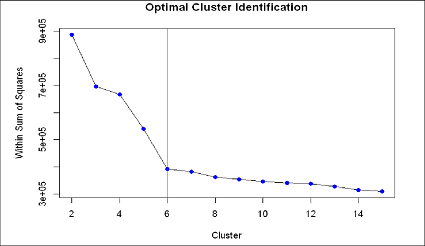
3. Silhouette score
4. Calinski Harabasz score: Variance Ratio Criterio이라고도 알려짐. between-clusters dispersion mean 과 within-cluster dispersion의 비율. 값이 높을수록 군집화가 잘 되었음을 의미
- 기타 지표 [참고](https://hongl.tistory.com/161)

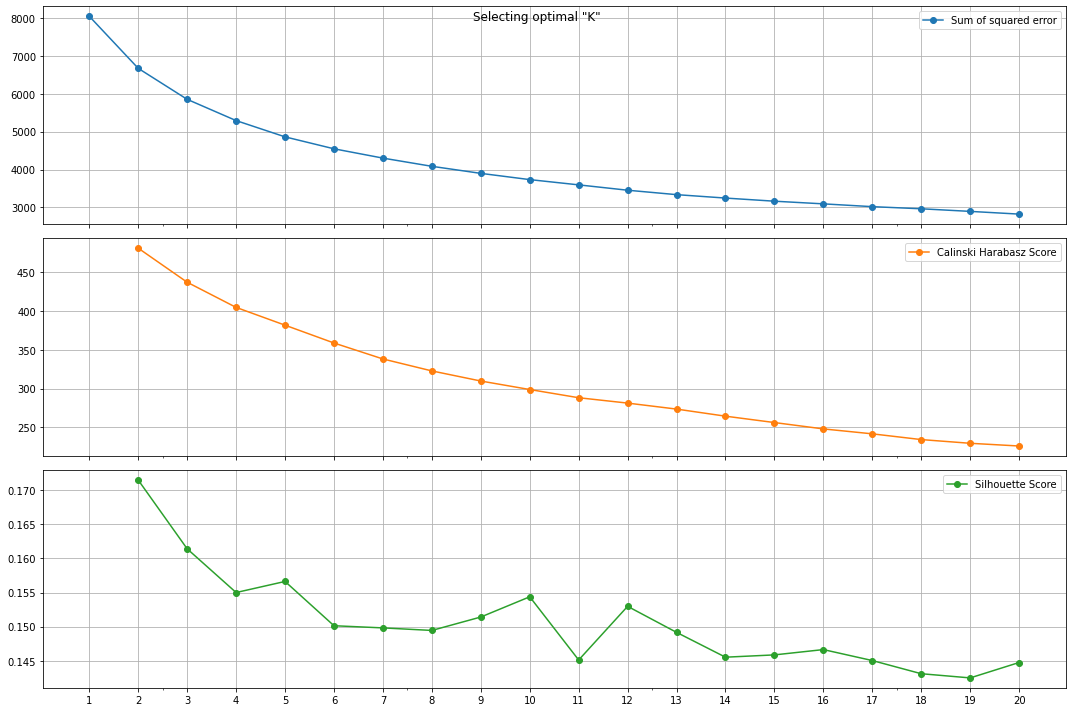

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import calinski_harabasz_score, silhouette_score

search_range = range(1, 21)
report = {}
for k in search_range:
    temp_dict = {}
    kmeans = KMeans(init='k-means++',
                    algorithm='auto',
                    n_clusters=k,
                    max_iter=1000,
                    random_state=1,
                    verbose=0).fit(data_prime)
    inertia = kmeans.inertia_
    temp_dict['Sum of squared error'] = inertia
    try:
        cluster = kmeans.predict(data_prime)
        chs = calinski_harabasz_score(data_prime, cluster)
        ss = silhouette_score(data_prime, cluster)
        temp_dict['Calinski Harabasz Score'] = chs
        temp_dict['Silhouette Score'] = ss
        report[k] = temp_dict
    except:
        report[k] = temp_dict

report_df = pd.DataFrame(report).T
report_df.plot(figsize=(15, 10),
               xticks=search_range,
               grid=True,
               title=f'Selecting optimal "K"',
               subplots=True,
               marker='o',
               sharex=True)
plt.tight_layout()

## Step 2. K-means clustering

In [ ]:
model = KMeans(n_clusters=5, random_state=312, algorithm='auto')
model.fit(data_prime)

KMeans(n_clusters=5, random_state=312)

In [ ]:
# 각 군집(cluster) 표시
pred = model.predict(data_prime)
pred

array([3, 3, 4, ..., 4, 0, 2], dtype=int32)

In [ ]:
# 군집별 centroids의 좌표값
centers = model.cluster_centers_
pd.DataFrame(centers, columns = data.columns)

Neuroticism  Extraversion  Conscientiousness  Agreeableness   Openess
0    -0.747647      0.422308           0.522702       0.355185  0.267290
1     0.102650     -0.217124           0.229613      -0.212094 -1.008630
2     0.174221     -1.005625           0.000890      -0.619786  0.587663
3    -0.331343      0.106151          -1.030252       0.252091 -0.126438
4     1.107615      0.445493           0.117704       0.227376  0.267516

## Step 3. Evaluation

In [ ]:
from sklearn.metrics import silhouette_samples, silhouette_score
data_prime['k_means_cluster'] = pred
data_prime['k_silhouette_coeff'] = silhouette_samples(data_prime, data_prime['k_means_cluster'])

k_average_score = silhouette_score(data_prime, data_prime['k_means_cluster'])
print('Average Silhouette Score:{0:.3f}'.format(k_average_score))

Average Silhouette Score:0.298


In [ ]:
# 군집별 평균 silhouette_score 값
data_prime.groupby('k_means_cluster')['k_silhouette_coeff'].mean()

k_means_cluster
0    0.374042
1    0.233004
2    0.235230
3    0.278856
4    0.317717
Name: k_silhouette_coeff, dtype: float64

## Step 4. EDA

In [ ]:
# 군집별 통계
data_prime.groupby('k_means_cluster').mean()

Neuroticism  Extraversion  Conscientiousness  Agreeableness  \
k_means_cluster                                                                
0                  -0.747647      0.422308           0.522702       0.355185   
1                   0.102650     -0.217124           0.229613      -0.212094   
2                   0.174221     -1.005625           0.000890      -0.619786   
3                  -0.331343      0.106151          -1.030252       0.252091   
4                   1.107615      0.445493           0.117704       0.227376   

                  Openess  k_silhouette_coeff  
k_means_cluster                                
0                0.267290            0.374042  
1               -1.008630            0.233004  
2                0.587663            0.235230  
3               -0.126438            0.278856  
4                0.267516            0.317717

- Cluster0: 신경질적이지 않고(-N) 성실한(C) 사람
- Cluster1: 개방적이지 않은(-O) 사람
- Cluster2: 외향적이지 않고(-E) 쾌활하지 않은(-A) 사람
- Cluster3: 성실하지 않은(-C) 사람
- Cluster4: 신경질적인(N) 사람

In [ ]:
data_prime.groupby('k_means_cluster').std()

Neuroticism  Extraversion  Conscientiousness  Agreeableness  \
k_means_cluster                                                                
0                   0.515664      0.595511           0.491930       0.622350   
1                   0.751084      0.718431           0.675426       0.724939   
2                   0.771411      0.626666           0.745757       0.748576   
3                   0.651125      0.757420           0.514657       0.679503   
4                   0.548380      0.657630           0.743163       0.665218   

                  Openess  k_silhouette_coeff  
k_means_cluster                                
0                0.593479            0.092286  
1                0.475892            0.085687  
2                0.654246            0.089870  
3                0.698537            0.093677  
4                0.624678            0.091253

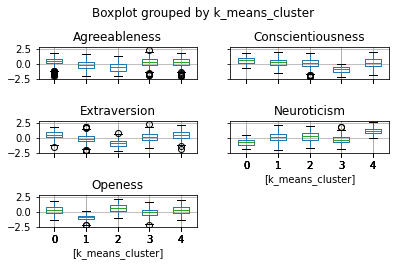

In [ ]:
# 시각화방법
data_prime.drop('k_silhouette_coeff', axis=1).boxplot(by='k_means_cluster')
plt.tight_layout(pad=3, h_pad=1)
plt.show()

#2. 주성분 분석
- 차원의 저주: 변수(차원)가 증가하면서 고차원으로 갈수록 희소(sparse)해짐 (무작위로 두 점의 평균 거리를 산출했을 때 그 거리가 멀어짐)
- 해결하기 위해 엄청나게 많은 데이터를 확보하는 방법이 있지만, 차원이 늘어날수록 필요한 데이터의 양이 기하급수적으로 증가하여, 현실적으로는 불가능
- 이를 해결하기 위해, 데이터를 저차원으로 투영하는 방법과, 매니폴드를 학습하는 방법이 있음 (참고)
- 매니폴드를 학습하는 것은 시각화에 있어서는 장점이지만 다루기 까다롭고 느림
- 저차원으로 투영을 통해 차원 축소를 진행

- "데이터를 정사영시켜 차원을 낮춘다면, 어떤 벡터에 정사영 시키는 것이 원 데이터 구조를 잘 유지할 수 있을까"에 대한 분석
- 데이터 벡터를 어떤 벡터에 정사영하는 것이 최적의 결과일지
정사영할 벡터를 찾을 때 데이터 분포의 중심을 축(pivot)으로 하는 벡터를 찾는 것이 좋지 않을지
- PCA의 가정
1) 대상이 되는 데이터는 linear하며, 우리가 찾은 선들은 직교
linear한 것을 가정, 선형 결합으로 표현하기 때문에 비선형 데이터에 취약할 수 있음
2) 큰 분산을 가지는 축이 중요한 정보를 가지고 있을 것
분산이 높다는 것은, 감소시킨 차원이 일정 부분 변화할 때 기존 변수도 높은 관계성을 가지고 변화한다는 것을 의미
3) 공분산: feature pairs의 변동이 얼마나 유사한지. 즉, 하나의 feature이 변화할 때 다른 feature의 변화가 얼마나 유사한지

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.decomposition import PCA

# 필요한 패키지/모듈 가져오기
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
%matplotlib inline

Description
25 personality self report items taken from the International Personality Item Pool (ipip.ori.org) were included as part of the Synthetic Aperture Personality Assessment (SAPA) web based personality assessment project. The data from 2800 subjects are included here as a demonstration set for scale construction, factor analysis, and Item Response Theory analysis. Three additional demographic variables (sex, education, and age) are also included. This data set is deprecated and users are encouraged to use bfi.
A data frame with 2800 observations on the following 28 variables. (The q numbers are the SAPA item numbers).
features
A1: Am indifferent to the feelings of others. (q_146)
A2: Inquire about others' well-being. (q_1162)
A3: Know how to comfort others. (q_1206)
A4: Love children. (q_1364)
A5: Make people feel at ease. (q_1419)
C1: Am exacting in my work. (q_124)
C2: Continue until everything is perfect. (q_530)
C3: Do things according to a plan. (q_619)
C4: Do things in a half-way manner. (q_626)
C5: Waste my time. (q_1949)
E1: Don't talk a lot. (q_712)
E2: Find it difficult to approach others. (q_901)
E3: Know how to captivate people. (q_1205)
E4: Make friends easily. (q_1410)
E5: Take charge. (q_1768)
N1: Get angry easily. (q_952)
N2: Get irritated easily. (q_974)
N3: Have frequent mood swings. (q_1099)
N4: Often feel blue. (q_1479)
N5: Panic easily. (q_1505)
O1: Am full of ideas. (q_128)
O2: Avoid difficult reading material.(q_316)
O3: Carry the conversation to a higher level. (q_492)
O4: Spend time reflecting on things. (q_1738)
O5: Will not probe deeply into a subject. (q_1964)
gender: Males = 1, Females = 2
education: 1 = HS, 2 = finished HS, 3 = some college, 4 = college graduate 5 = graduate degree
age: age in years
Source: https://vincentarelbundock.github.io/Rdatasets/doc/psych/bfi.html
Data Source: https://vincentarelbundock.github.io/Rdatasets/datasets.html

In [ ]:
data = pd.read_csv('https://raw.githubusercontent.com/jej0312/DM_TA/main/data/bfi.csv', index_col =0)
data.drop(['gender', 'education', 'age'], axis=1, inplace=True)
data.dropna(inplace=True)
# data.columns = ['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'x11', 'x12', 'x13', 'x14', 'x15', 'x16', 'x17', 'x18', 'x19', 'x20', 'x21', 'x22', 'x23', 'x24', 'x25']
data.head()

A1   A2   A3   A4   A5   C1   C2   C3   C4   C5  ...   N1   N2   N3  \
61617  2.0  4.0  3.0  4.0  4.0  2.0  3.0  3.0  4.0  4.0  ...  3.0  4.0  2.0   
61618  2.0  4.0  5.0  2.0  5.0  5.0  4.0  4.0  3.0  4.0  ...  3.0  3.0  3.0   
61620  5.0  4.0  5.0  4.0  4.0  4.0  5.0  4.0  2.0  5.0  ...  4.0  5.0  4.0   
61621  4.0  4.0  6.0  5.0  5.0  4.0  4.0  3.0  5.0  5.0  ...  2.0  5.0  2.0   
61622  2.0  3.0  3.0  4.0  5.0  4.0  4.0  5.0  3.0  2.0  ...  2.0  3.0  4.0   

        N4   N5   O1  O2   O3   O4   O5  
61617  2.0  3.0  3.0   6  3.0  4.0  3.0  
61618  5.0  5.0  4.0   2  4.0  3.0  3.0  
61620  2.0  3.0  4.0   2  5.0  5.0  2.0  
61621  4.0  1.0  3.0   3  4.0  3.0  5.0  
61622  4.0  3.0  3.0   3  4.0  3.0  3.0  

[5 rows x 25 columns]

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2436 entries, 61617 to 67560
Data columns (total 25 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   A1      2436 non-null   float64
 1   A2      2436 non-null   float64
 2   A3      2436 non-null   float64
 3   A4      2436 non-null   float64
 4   A5      2436 non-null   float64
 5   C1      2436 non-null   float64
 6   C2      2436 non-null   float64
 7   C3      2436 non-null   float64
 8   C4      2436 non-null   float64
 9   C5      2436 non-null   float64
 10  E1      2436 non-null   float64
 11  E2      2436 non-null   float64
 12  E3      2436 non-null   float64
 13  E4      2436 non-null   float64
 14  E5      2436 non-null   float64
 15  N1      2436 non-null   float64
 16  N2      2436 non-null   float64
 17  N3      2436 non-null   float64
 18  N4      2436 non-null   float64
 19  N5      2436 non-null   float64
 20  O1      2436 non-null   float64
 21  O2      2436 non-null   int64  
 22  

PCA을 수행하기 전 standardization을 통해 분산을 고정하는 것이 중요함

데이터의 스케일에 따라 주성분의 설명 가능한 분산량이 달라질 수 있음
따라서, scaling(centering)을 통해 변수가 가진 값의 크기에 따라 설명 가능한 분산량이 왜곡되는 것에 따른 모델 성능이 저하를 방지함
예를 들어, 키(m)와 몸무게(kg)가 다른 scale을 가지고 있을 때 (키가 더 적게 변화) scaling을 하지 않으면 몸무게가 maximal variance의 방향을 결정할 것임. 따라서 키(m)의 변화 1은 몸무게(kg)의 변화 1보다 더 중요하게 반영이 될 것인데 이렇게 다른 가중치를 두는 것을 옳지 않음
공분산 행렬을 계산할 때 각 feature의 평균은 0으로 맞춰주어야 결과에 대해 직관적으로 해석하기 용이함

In [ ]:
# 열별로 scaling (z-standardization)
from sklearn.preprocessing import StandardScaler
data_scale = pd.DataFrame(StandardScaler().fit_transform(data), columns=data.columns, index = data.index)

In [ ]:
data_scale.mean(axis=0).head()

A1    1.400084e-16
A2   -4.200253e-16
A3   -2.245968e-16
A4    1.079232e-16
A5   -2.741832e-16
dtype: float64

In [ ]:
data_scale.cov() # 공분산행렬

A1        A2        A3        A4        A5        C1        C2  \
A1  1.000411 -0.351050 -0.273748 -0.156818 -0.192777  0.014704  0.012924   
A2 -0.351050  1.000411  0.503248  0.351000  0.397563  0.103025  0.129627   
A3 -0.273748  0.503248  1.000411  0.385076  0.515890  0.114258  0.146571   
A4 -0.156818  0.351000  0.385076  1.000411  0.325778  0.094851  0.226547   
A5 -0.192777  0.397563  0.515890  0.325778  1.000411  0.134747  0.116911   
C1  0.014704  0.103025  0.114258  0.094851  0.134747  1.000411  0.438403   
C2  0.012924  0.129627  0.146571  0.226547  0.116911  0.438403  1.000411   
C3 -0.020595  0.188895  0.129444  0.133119  0.130873  0.317400  0.362975   
C4  0.115121 -0.146355 -0.121165 -0.172342 -0.125582 -0.362640 -0.396252   
C5  0.038309 -0.121156 -0.153875 -0.249778 -0.167105 -0.261187 -0.303944   
E1  0.107223 -0.222371 -0.210452 -0.133655 -0.252414 -0.030519  0.017059   
E2  0.087958 -0.243183 -0.291983 -0.210066 -0.338624 -0.106841 -0.075263   
E3 -0.048933  0.255171  0.383288  0.204461  0.412000  0.134823  0.153020   
E4 -0.069810  0.297247  0.387790  0.319066  0.482756  0.153270  0.122951   
E5 -0.020191  0.294312  0.253567  0.168943  0.268726  0.267939  0.257942   
N1  0.168348 -0.093666 -0.083300 -0.106689 -0.204849 -0.071984 -0.019959   
N2  0.139871 -0.050496 -0.092511 -0.155352 -0.198918 -0.038196 -0.005588   
N3  0.092404 -0.040424 -0.039174 -0.073918 -0.138529 -0.025487  0.003190   
N4  0.042157 -0.086771 -0.127160 -0.171298 -0.215434 -0.098075 -0.044359   
N5  0.015187  0.019696 -0.040159 -0.015142 -0.081438 -0.047989  0.051233   
O1  0.005784  0.125685  0.150148  0.057099  0.162663  0.179323  0.161108   
O2  0.066203  0.013964  0.006590  0.037779 -0.006991 -0.129316 -0.057370   
O3 -0.063814  0.165387  0.226426  0.071012  0.238289  0.196643  0.192760   
O4 -0.090549  0.082643  0.032280 -0.049814  0.011359  0.100231  0.047446   
O5  0.099206 -0.080871 -0.041768  0.027319 -0.050470 -0.130525 -0.066617   

          C3        C4        C5  ...        N1        N2        N3        N4  \
A1 -0.020595  0.115121  0.038309  ...  0.168348  0.139871  0.092404  0.042157   
A2  0.188895 -0.146355 -0.121156  ... -0.093666 -0.050496 -0.040424 -0.086771   
A3  0.129444 -0.121165 -0.153875  ... -0.083300 -0.092511 -0.039174 -0.127160   
A4  0.133119 -0.172342 -0.249778  ... -0.106689 -0.155352 -0.073918 -0.171298   
A5  0.130873 -0.125582 -0.167105  ... -0.204849 -0.198918 -0.138529 -0.215434   
C1  0.317400 -0.362640 -0.261187  ... -0.071984 -0.038196 -0.025487 -0.098075   
C2  0.362975 -0.396252 -0.303944  ... -0.019959 -0.005588  0.003190 -0.044359   
C3  1.000411 -0.357971 -0.351093  ... -0.079126 -0.066908 -0.077447 -0.122225   
C4 -0.357971  1.000411  0.487751  ...  0.215940  0.158411  0.201988  0.270744   
C5 -0.351093  0.487751  1.000411  ...  0.216503  0.246400  0.241698  0.354810   
E1 -0.009049  0.098521  0.067697  ...  0.014874  0.020189  0.054747  0.235129   
E2 -0.089281  0.207909  0.266471  ...  0.176266  0.206612  0.193576  0.351446   
E3  0.092602 -0.084580 -0.163325  ... -0.046699 -0.059931 -0.016671 -0.146640   
E4  0.099578 -0.112588 -0.207302  ... -0.143583 -0.152254 -0.122693 -0.306620   
E5  0.207573 -0.235109 -0.234930  ...  0.034068  0.038937 -0.065357 -0.207257   
N1 -0.079126  0.215940  0.216503  ...  1.000411  0.718555  0.567579  0.410037   
N2 -0.066908  0.158411  0.246400  ...  0.718555  1.000411  0.550286  0.395000   
N3 -0.077447  0.201988  0.241698  ...  0.567579  0.550286  1.000411  0.523485   
N4 -0.122225  0.270744  0.354810  ...  0.410037  0.395000  0.523485  1.000411   
N5 -0.023518  0.197143  0.179083  ...  0.380751  0.350939  0.430806  0.403088   
O1  0.091179 -0.093599 -0.085665  ... -0.051290 -0.043038 -0.039701 -0.048723   
O2 -0.029616  0.208158  0.122646  ...  0.135282  0.117089  0.104266  0.074068   
O3  0.058904 -0.083061 -0.074159  ... -0.039231 -0.029648 -0.028240 -0.062941   
O4  0.011365  0.053036  0.135538  ...  0.078828  0.130981  0.165807  0.220218   
O5 -0.00

Step 2. Principle component 수 선택
PC 선택: 몇 개까지 선택할지는 분석가의 결정에 따름
방안 1: Eigen value가 1 이상일 때까지
방안 2: Scree plot 그래프 기울기가 완만해지기 전의 값까지
방안 3: 약 80% 이상의 분산을 설명하는 PC 개수 채택

In [ ]:
# PCA 진행
pca = PCA(random_state=312)
X_p = pca.fit_transform(data_scale)

-  Scree plot 그래프 기울기가 완만해지기 전까지
Scree plot: 고유값-주성분의 분산 변화를 보는 그래프로, 고유값 변화율이 완만해지는 부분이 필요한 주성분의 수

In [ ]:
# 분산 설명 비율
each_variance_ratio = pca.explained_variance_ratio_
print('분산 설명 비율:\n', each_variance_ratio) # 각 PC별 분산 설명 비율

cumsum = np.cumsum(each_variance_ratio)
print('누적 분산 설명 비율:\n', cumsum) # 고유값을 기준으로 설명 가능한 분산 (누적)

분산 설명 비율:
 [0.20537245 0.11007547 0.08570808 0.0740931  0.06192651 0.0429433
 0.03358156 0.03196825 0.02875957 0.02752355 0.02705493 0.02607199
 0.02493012 0.02386251 0.02252363 0.02173221 0.0205807  0.01978013
 0.01930558 0.01795684 0.01693464 0.01602686 0.01551218 0.01527427
 0.01050156]
누적 분산 설명 비율:
 [0.20537245 0.31544791 0.40115599 0.4752491  0.53717561 0.58011891
 0.61370047 0.64566871 0.67442828 0.70195183 0.72900677 0.75507876
 0.78000888 0.80387139 0.82639503 0.84812724 0.86870794 0.88848807
 0.90779365 0.92575049 0.94268513 0.95871199 0.97422417 0.98949844
 1.        ]


PC 6까지 채택할 경우, 누적 분산 설명 비율은 약 58%

방안 3. 약 80% 이상의 분산을 설명하는 PC 건수 채택

In [ ]:
d = np.argmax(cumsum >= 0.80) +1 #누적된 설명가능한 분산의 비율이 0.85 이상
print('적합한 PC 개수:', d) # 17개 선택 (PC16까지 활용)

적합한 PC 개수: 14


Step 3. PCA
방안 1, 방안 2에서 공통적으로 제시한 결과를 기반으로, PC 6까지 사용하여 실습을 진행

In [ ]:
# 각 PC를 이루는 변수들의 조합 구성 (25X6): Eigen Vector
pd.DataFrame(pca.components_[:,:6],
             columns = ['PC1','PC2','PC3','PC4','PC5','PC6'],
             index=data.columns)

PC1       PC2       PC3       PC4       PC5       PC6
A1  0.110202 -0.218902 -0.245872 -0.201804 -0.270364 -0.165829
A2  0.015719 -0.188571 -0.190528 -0.075120 -0.113973 -0.092649
A3  0.118324 -0.153905 -0.201259 -0.129908 -0.210261  0.357013
A4  0.029509  0.090576  0.067831  0.241235  0.016945  0.153227
A5  0.490281 -0.333324 -0.255208 -0.189163 -0.150969  0.032915
C1 -0.422041  0.162960 -0.043447 -0.046223 -0.187215 -0.125232
C2  0.194210 -0.159139  0.127331  0.502886  0.047269 -0.203797
C3  0.040235  0.242298  0.164480  0.119154 -0.091919 -0.330289
C4  0.195248 -0.031171 -0.004665  0.395280 -0.036071  0.208255
C5  0.207383 -0.086872 -0.119081  0.113891 -0.003064 -0.425534
E1  0.230832 -0.044491  0.315460 -0.328029  0.432253  0.179712
E2 -0.195680 -0.133505 -0.037033  0.125792 -0.095074  0.128305
E3 -0.392696 -0.296260  0.048634 -0.271432 -0.002915 -0.091515
E4  0.041673  0.012441  0.045402  0.007252  0.010874 -0.134011
E5 -0.016407 -0.053556 -0.025337  0.172484 -0.254954 -0.217247
N1  0.229980  0.252612 -0.136914 -0.077559 -0.023398 -0.057846
N2  0.125838 -0.086234  0.096534 -0.123900  0.245375 -0.384982
N3  0.198142  0.278735  0.125733 -0.297505 -0.013912 -0.257984
N4 -0.271262 -0.304370 -0.386350  0.086941  0.436748 -0.225680
N5 -0.055620  0.111299  0.143735 -0.157595 -0.362582 -0.039862
O1 -0.019829 -0.450869  0.551804 -0.034680  0.005892  0.000948
O2  0.020874 -0.230460  0.194413  0.149635 -0.159082  0.035404
O3  0.002135  0.031397 -0.065868  0.055157  0.011115  0.114567
O4  0.022135  0.152390 -0.255003  0.056343  0.360360  0.117636
O5  0.000779  0.096172 -0.047424 -0.073122  0.009069 -0.000278

In [ ]:
X_pp = pd.DataFrame(X_p[:,:6],
                    columns = ['PC1','PC2','PC3','PC4','PC5','PC6'],
                    index = data.index)

X_pp # PCA 이후 만들어진 data (PC1~ PC6로 총 6개 변수로 축소)

PC1       PC2       PC3       PC4       PC5       PC6
61617  2.370299  1.856536 -2.561254  0.500794  0.766565  0.552017
61618  0.372980 -0.147845 -1.126236 -0.307562  0.999889  0.623553
61620  0.831955 -0.659628  0.507829 -0.425028  1.566589  0.140086
61621  1.468606  1.063837 -2.140233  0.567288  0.684166 -1.389421
61622  0.350837  1.004977 -0.621911  0.726829  1.533974  0.672661
...         ...       ...       ...       ...       ...       ...
67547  4.066964 -1.053212  2.068989 -0.581108  0.216626  0.849262
67549  0.770074 -1.500500  0.446098 -2.009404  0.811757 -1.047096
67556 -1.568841  0.190316  1.643275 -0.783050  1.882051  0.596238
67559  1.539287 -0.941642  1.675189 -1.227477  3.000000  0.007268
67560  2.237448  4.406015  1.715835 -0.677612  0.130968  1.594809

[2436 rows x 6 columns]